In [1]:
#Packages 
import numpy as np
import xarray as xr
import xroms
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import warnings
warnings.filterwarnings("ignore") #turns off annoying warnings

In [2]:
def open_roms(path):
    chunk = {"xi": -1, "eta": -1, "ocean_time": -1} 
    chunks = {}
    for sub in ["rho", "u", "v", "psi"]:
        for k, v in chunk.items():
            chunks[f"{k}_{sub}"] = v
    chunks["ocean_time"] = chunk["ocean_time"]

    ds = xroms.open_netcdf(path,chunks=chunks)
    ds,grid = xroms.roms_dataset(ds,include_cell_volume=True)
    ds.xroms.set_grid(grid)
    return ds,grid

In [3]:
#Sample model output
path = '/pscratch/sd/d/dylan617/txla_roms/runs/forecast_test/TXLA2.ocn.his.2024_07_15_f.nc'
ds,grid = open_roms(path)

#Open the river files from natural earth. 
rpath = '/global/u2/d/dylan617/repos/notebooks/txla_roms/natural_earth/ne_10m_rivers_north_america.shp'
rivers = ShapelyFeature(Reader(rpath).geometries(),
                        ccrs.PlateCarree(), facecolor='none', edgecolor = 'blue')

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

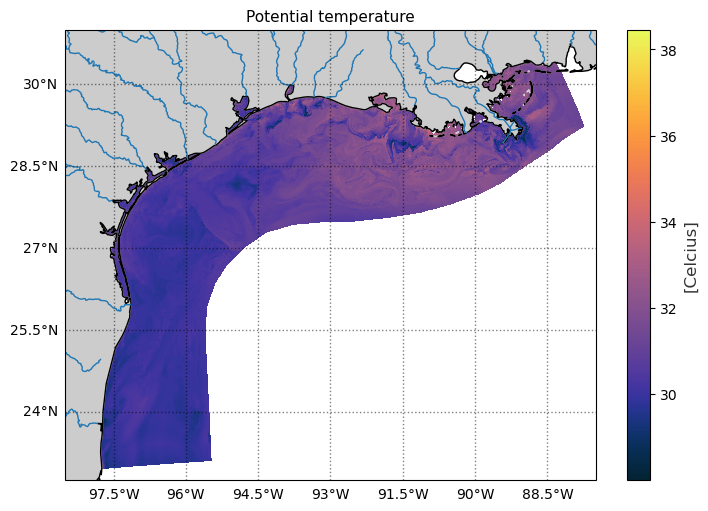

In [5]:
lat_rad = 1.0/np.cos(np.radians(ds.lat_rho.mean().values))
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1, figsize = (7.5,5), 
                      subplot_kw={'projection': crs}, 
                      constrained_layout = True)

mappable = ax.pcolormesh(ds.lon_rho,
                       ds.lat_rho,
                       ds.temp.isel(ocean_time=-1, s_rho = -1), 
                       cmap = cmo.thermal,
                       # vmin = 15, vmax = 35,
                       transform = crs)
ax.set_extent([-98.5, -87.5, 22.75, 31], crs)
ax.set_aspect(lat_rad)
cb = fig.colorbar(mappable)
cb.set_label(r'[Celcius]', fontsize=12, color='0.2')

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1)
ax.coastlines(resolution='10m', linewidth = 1)  

# The extra rivers file is incomplete. We have to add the shape file 
# and the default one from cartopy. The colors of the river also mismatch, 
# so manually prescribe them 
ax.add_feature(rivers, linewidth=1, edgecolor = 'tab:blue')
ax.add_feature(cartopy.feature.RIVERS, linewidth=1, color = 'tab:blue')

ax.set_title('Potential temperature', fontsize = 11)
fig.canvas.draw()